# Mount google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive/')
data_path = '/content/drive/My Drive/Colab Notebooks/predict_future_sales/data/prep/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


# Install libs

In [2]:
!pip install sparse_dot_topn

     |████████████████████████████████| 61kB 2.5MB/s 
  Created wheel for sparse-dot-topn: filename=sparse_dot_topn-0.2.5-cp36-cp36m-linux_x86_64.whl size=98256 sha256=d2bae483ca8590d05c6ce463fbc750eba6c46967144beaee75280bebb925cdeb
  Stored in directory: /root/.cache/pip/wheels/f5/de/86/f644ccba76566c3e0dc0aafa4b4b57164a11760606f69dce22
Successfully built sparse-dot-topn


# Import libs

In [0]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime
from itertools import product
import gc
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from statsmodels.tsa.seasonal import seasonal_decompose
from pytz import timezone
import time

mpl.rcParams['figure.figsize'] = [8.0, 6.0]

# Load Data

In [0]:
sales = pd.read_pickle(data_path + 'sales.pkl')
test = pd.read_pickle(data_path + 'test.pkl')
items = pd.read_pickle(data_path + 'items.pkl')
categories = pd.read_pickle(data_path + 'item_categories.pkl')
shops = pd.read_pickle(data_path + 'shops.pkl')

sales = sales.merge(items[['item_id', 'item_category_id']], on = 'item_id', how = 'inner')

index_cols = ['shop_id', 'item_id', 'date_block_num'] 

# Utile Functions

In [0]:
def downcast_dtypes(df):
    start_size = df.memory_usage(deep = True).sum() / 1024**2
    print('Memory usage: {:.2f} MB'.format(start_size))

    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols = [c for c in df if df[c].dtype in ["int64", "int32"]]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    end_size = df.memory_usage(deep = True).sum() / 1024**2
    print('New Memory usage: {:.2f} MB'.format(end_size))
    return df

def create_target_for_attribute(df, attr, target, time_col, aggfunc = np.sum, fill = 0):
    target_for_attr = df.pivot_table(index = [attr],
                                   values = [target],
                                   columns = time_col, 
                                   aggfunc = aggfunc,
                                   fill_value = fill,
                                  ).reset_index()
  
    target_for_attr.columns = target_for_attr.columns.droplevel().map(str)
    target_for_attr = target_for_attr.reset_index(drop = True).rename_axis(None, axis = 1)
    target_for_attr.columns.values[0] = attr
    return target_for_attr

def create_target_for_attributes(df, attrs, target, time_col, aggfunc = np.sum, fill = 0):
    target_for_attrs = df.pivot_table(index = attrs,
                                   values = target, 
                                   columns = time_col, 
                                   aggfunc = aggfunc, 
                                   fill_value = fill,
                                  ).reset_index()
    target_for_attrs.columns = target_for_attrs.columns.map(str)
    target_for_attrs = target_for_attrs.reset_index(drop = True).rename_axis(None, axis = 1)
    return target_for_attrs

def create_train_set(df, index_cols = index_cols):
    grid = []
  #curr_shops = df['shop_id'].unique()
  #curr_items = df['item_id'].unique()
    for month in df['date_block_num'].unique():
        curr_shops = df[df['date_block_num'] == month]['shop_id'].unique()
        curr_items = df[df['date_block_num'] == month]['item_id'].unique()
        grid.append(np.array(list(product(*[curr_shops, curr_items, [month]])), dtype = 'int32'))

    grid = pd.DataFrame(np.vstack(grid), columns = index_cols, dtype = np.int32)

    gb = df.groupby(index_cols, as_index = False).agg({'item_cnt_day':'sum'})
    gb.columns = index_cols + ['target']
    all_data = pd.merge(grid, gb, how = 'left', on = index_cols).fillna(0)
    all_data.sort_values(['date_block_num','shop_id','item_id'], inplace = True)
    all_data.loc[:, 'target'] = all_data['target'].clip(0, 20).astype(np.float32)
    print('Sales data shape:', df.shape)
    print('Generated Train data shape:', all_data.shape)
    del curr_shops
    del curr_items
    del gb
    del grid
    gc.collect()
    return all_data

def generate_name(my_name):
    now = datetime.datetime.now(timezone('Europe/Berlin'))
    name_id = now.strftime("%H_%M_%S__%d_%h_%Y")
    return my_name + '_' + name_id

# Construct Training data

- Collect shops, items that have been sold in each month form sales dataframe.
- Generate all possible triples for (shop_id, item_id, date_block_num)
- Group sales dataframe according to (shop_id, item_id, date_block_num) and calculate the sum of target
- Merge the generated triples with the grouped dataframe
- Sort the result dataframe according to month, shop and item


In [0]:
all_data = create_train_set(sales)

Sales data shape: (2935842, 7)
Generated Train data shape: (10809347, 4)


# Baseline Model

In [0]:
all_data = all_data.merge(items, on = 'item_id', how = 'left')
all_data = all_data.merge(shops, on = 'shop_id', how = 'left')
all_data = all_data.merge(categories, on = 'item_category_id', how = 'left')

In [0]:
features = all_data.columns.values
features = features[(features != 'target') & (features != 'date_block_num')]
X = all_data.loc[:, features]
y = all_data.loc[:, 'target']

In [0]:
X_enc = X.copy()
X_enc = X_enc.fillna('Unknow')
cat_features = []
  for col in X.columns:
    if X_enc[col].dtypes == np.object:
      cat_features.append(X_enc.columns.get_loc(col))
      X_enc.loc[:, col] = LabelEncoder().fit_transform(X_enc[col].values)

In [0]:
lgb_params = {
    'feature_fraction': 0.75,
    'metric': 'rmse',
    'nthread':1, 
    'min_data_in_leaf': 2**7, 
    'bagging_fraction': 0.75, 
    'learning_rate': 0.03, 
    'objective': 'mse', 
    'bagging_seed': 2**7, 
    'num_leaves': 2**7,
    'bagging_freq':1,
    'verbose':0,
}
d_train = lgb.Dataset(X_enc, label = y)
gb_model = lgb.train(lgb_params, d_train, 100)

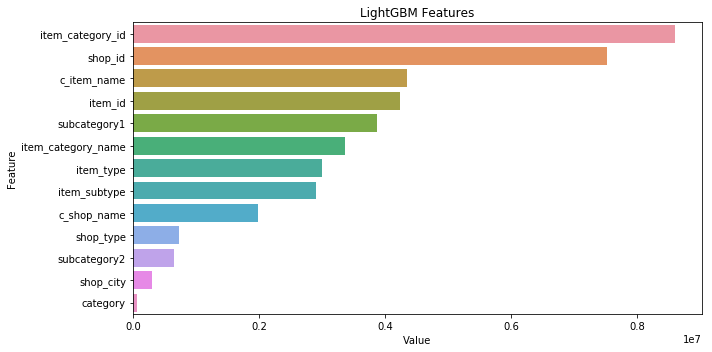

In [0]:
feature_importance = pd.DataFrame(sorted(zip(gb_model.feature_importance(importance_type = 'gain'), X_enc.columns)), columns=['Value','Feature'])
plt.figure(figsize = (10, 5))
sns.barplot(x = "Value", y = "Feature", data = feature_importance.sort_values(by = "Value", ascending = False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

# Global Variables

In [8]:
start = time.time()

items_sales = create_target_for_attribute(sales, 'item_id', 'item_cnt_day', 'date_block_num', aggfunc = np.sum, fill = 0)
items_trans = create_target_for_attribute(sales, 'item_id', 'item_cnt_day', 'date_block_num', aggfunc = np.count_nonzero, fill = 0)
items_prices = create_target_for_attribute(sales, 'item_id', 'item_price', 'date_block_num', aggfunc = np.median, fill = np.nan)

shops_sales = create_target_for_attribute(sales, 'shop_id', 'item_cnt_day', 'date_block_num', aggfunc = np.sum, fill = 0)
shops_trans = create_target_for_attribute(sales, 'shop_id', 'item_cnt_day', 'date_block_num', aggfunc = np.count_nonzero, fill = 0)
#shops_prices = create_target_for_attribute(sales, 'shop_id', 'item_price', 'date_block_num', aggfunc = np.median, fill  = np.nan)

categories_sales = create_target_for_attribute(sales, 'item_category_id', 'item_cnt_day', 'date_block_num', aggfunc = np.sum, fill = 0)
categories_trans = create_target_for_attribute(sales, 'item_category_id', 'item_cnt_day', 'date_block_num', aggfunc = np.count_nonzero, fill = 0)
#categories_prices = create_target_for_attribute(sales, 'item_category_id', 'item_price', 'date_block_num', aggfunc = np.median, fill = np.nan)

shops_items_sales = create_target_for_attributes(sales, ['shop_id', 'item_id'], 'item_cnt_day', 'date_block_num', aggfunc = np.sum, fill = 0)
shops_items_trans = create_target_for_attributes(sales, ['shop_id', 'item_id'], 'item_cnt_day', 'date_block_num', aggfunc = np.count_nonzero, fill = 0)
shops_items_sales.loc[:, '0':] = shops_items_sales.loc[:, '0':].clip(0, 20)

print(round(time.time() - start), 'seconds')

79 seconds


# Feature Engineering

Before we go crazy generating features, let us look again to the data.

In [9]:
test_items = set(test.item_id)
sales_items = set(sales.item_id)
items_in_test_and_sales = test_items.intersection(sales_items)
items_in_test_not_sales = test_items - sales_items.intersection(test_items)

print('There is sales history for:', len(items_in_test_and_sales) , ' items in test set out of', test['item_id'].nunique())
print('There is No sales history for:', len(items_in_test_not_sales), ' items in test set out of', test['item_id'].nunique())
print('---------------------')
shops_test = set(test.shop_id)
shops_train = set(sales.shop_id)
shops_in_test_and_sales = shops_test.intersection(shops_train)
shops_in_test_not_sales = set(test.shop_id) - shops_test.intersection(shops_train)
print('There is sales history for:', len(shops_in_test_and_sales), ' shops in test set out of', test['shop_id'].nunique())
print('There is No sales history for:', len(shops_in_test_not_sales), ' shops in test set out of', test['shop_id'].nunique())

There is sales history for: 4737  items in test set out of 5100
There is No sales history for: 363  items in test set out of 5100
---------------------
There is sales history for: 42  shops in test set out of 42
There is No sales history for: 0  shops in test set out of 42


In [10]:
ntest = test.reset_index()
found_sales = ntest.merge(sales, on = ['item_id','shop_id'], how = 'left').dropna()
pairs_with_history = ntest[ntest['ID'].isin(found_sales['ID'])]
pairs_with_no_item_history = ntest[~(ntest['item_id'].isin(sales['item_id']))]
pairs_with_just_item_history_num = test.shape[0] - (len(pairs_with_history) + len(pairs_with_no_item_history))

print('There is sales history for:', len(pairs_with_history) , ' shop/item pairs in test set out of', len(test))
print('There is No sales history for:',  len(pairs_with_no_item_history), ' shop/item in test set of', len(test))
print('There is sales history for:',  pairs_with_just_item_history_num, ' items ONLY from shop/item pairs in test set out of', len(test))
print('-------------------')
print('Total number of shop/item pairs in train set: ', len(shops_items_sales))
print('Total number of Possible shop/item pairs: ', len(items) * len(shops))

There is sales history for: 111543  shop/item pairs in test set out of 214200
There is No sales history for: 15246  shop/item in test set of 214200
There is sales history for: 87411  items ONLY from shop/item pairs in test set out of 214200
-------------------
Total number of shop/item pairs in train set:  416197
Total number of Possible shop/item pairs:  1219350


## Summerize

We have **214200** pairs of shop/item that we want to predict their future sales. Those pairs can be divided into 3 groups:
- **First group:** 111543 pairs with shop/item sales history. We know the previous sales of the item inside the shop
- **Second group:** 87411 pairs with item sales history. We know the previous sales of the items in different shops
- **Third group:** 15246 pairs have shop history. We know the previous sales of the shop only. The items have no sales history

The problem is modeled as: 


target_pair1(t = 0), target_pair1(t = 1), target_pair1(t = 2), ..., target_pair1(t = k) >>--->>predict>>--->> **target_pair1(t = 34)**.

target_pair2(t = 0), target_pair2(t = 1), target_pair2(t = 2), ..., target_pair2(t = k) >>--->>predict>>--->> **target_pair2(t = 34)**

- 
- 
- 

target_pair_m(t = 0), target_pair_m(t = 1), target_pair_m(t = 2), ..., target_pair_m(t = k) >>--->>predict>>--->> **target_pair_m(t = 34)**


**First Group:**
- lag features for target per (item, shop, item/shop)
- trend and seasonality

**Second Group:**
- lag features for target per(item, shop)
- trend and seasonality

**Third Group:**
- lag features for target per similar items in the same shop
- trend and seasonality




## Outdated shops/items/categories

In [0]:
outdated_limit = '27'

In [25]:
outdated_shops = shops_sales[shops_sales.loc[:, outdated_limit:].sum(axis = 1) <= 0]
print('shops in train set: ', len(shops_sales), ' out of', len(shops))
print('Outdated shops in train set: ', round(100 * len(outdated_shops) / len(shops_sales), 2), '%')

shops['shop_status'] = 'unknown'
shops.loc[shops['shop_id'].isin(outdated_shops['shop_id']), 'shop_status'] = 'deactive'

active_shops =  shops_sales[shops_sales.loc[:, outdated_limit:].sum(axis = 1) > 0]
shops.loc[shops['shop_id'].isin(active_shops['shop_id']), 'shop_status'] = 'active'

shops in train set:  55  out of 55
Outdated shops in train set:  12.73 %


In [26]:
outdated_items = items_sales[items_sales.loc[:, outdated_limit:].sum(axis = 1) <= 0]
print('items in train set: ', len(items_sales), ' out of', len(items))
print('Outdated items in train set: ', round(100 * len(outdated_items) /len(items_sales), 2), '%')

items['item_status'] = 'unknown'
items.loc[items['item_id'].isin(outdated_items['item_id']), 'item_status'] = 'deactive'

active_items =  items_sales[items_sales.loc[:,outdated_limit:].sum(axis = 1) > 0]
items.loc[items['item_id'].isin(active_items['item_id']), 'item_status'] = 'active'

items in train set:  21806  out of 22170
Outdated items in train set:  56.84 %


In [27]:
outdated_categories = categories_sales[categories_sales.loc[:, outdated_limit:].sum(axis = 1) <= 0]
print('categories in train set: ', len(categories_sales), ' out of', len(categories))
print('Outdated categories in train set: ',  round(100 * len(outdated_categories)/len(categories_sales), 2), '%')

categories['item_category_status'] = 'unknown'
categories.loc[categories['item_category_id'].isin(outdated_categories['item_category_id']), 'item_category_status'] = 'deactive'

active_categories = categories_sales[categories_sales.loc[:, outdated_limit:].sum(axis = 1) > 0]
categories.loc[categories['item_category_id'].isin(active_categories['item_category_id']), 'item_category_status'] = 'active'

categories in train set:  84  out of 84
Outdated categories in train set:  20.24 %


## Generate history for missing item

There is 363 items that we have no sales history at all. It could be that those items are outdated and nobody bought them during the 34 months. Or it could be the orgnizers of the competion took them form the train set.
- I will assume that those items have the same sales history like items with same type and category in same shop.
- I will give the rest the median of the sales of items in the same category and shop


### Find similar items

In [0]:
def ngrams(string, n=3):
    ngrams = zip(*[string[i:] for i in range(n)])
    return [''.join(ngram) for ngram in ngrams]

from scipy.sparse import csr_matrix
import sparse_dot_topn.sparse_dot_topn as ct
from sklearn.feature_extraction.text import TfidfVectorizer

def awesome_cossim_top(A, B, ntop, lower_bound=0):
    A = A.tocsr()
    B = B.tocsr()
    M, _ = A.shape
    _, N = B.shape
 
    idx_dtype = np.int32
 
    nnz_max = M*ntop
 
    indptr = np.zeros(M+1, dtype=idx_dtype)
    indices = np.zeros(nnz_max, dtype=idx_dtype)
    data = np.zeros(nnz_max, dtype=A.dtype)

    ct.sparse_dot_topn(
        M, N, np.asarray(A.indptr, dtype=idx_dtype),
        np.asarray(A.indices, dtype=idx_dtype),
        A.data,
        np.asarray(B.indptr, dtype=idx_dtype),
        np.asarray(B.indices, dtype=idx_dtype),
        B.data,
        ntop,
        lower_bound,
        indptr, indices, data)

    return csr_matrix((data,indices,indptr),shape=(M,N))
  
def get_matches_df(sparse_matrix, name_vector, top=100):
    non_zeros = sparse_matrix.nonzero()
    
    sparserows = non_zeros[0]
    sparsecols = non_zeros[1]
    
    if top:
        nr_matches = top
    else:
        nr_matches = sparsecols.size
    
    left_side = np.empty([nr_matches], dtype=object)
    right_side = np.empty([nr_matches], dtype=object)
    similairity = np.zeros(nr_matches)
    
    for index in range(0, nr_matches):
        left_side[index] = name_vector[sparserows[index]]
        right_side[index] = name_vector[sparsecols[index]]
        similairity[index] = sparse_matrix.data[index]
        
    df = pd.DataFrame({'left_side': left_side,
                          'right_side': right_side,
                           'similairity': similairity})
    
    return df.sort_values(['similairity'], ascending=False)

In [29]:
items_names = items['item_name']
vectorizer = TfidfVectorizer(min_df = 1, analyzer=ngrams)
tf_idf_matrix = vectorizer.fit_transform(items_names)
print('item_name tfid shape: ', tf_idf_matrix.shape)
matches = awesome_cossim_top(tf_idf_matrix, tf_idf_matrix.transpose(), 22170, 0.4)

matches_df = get_matches_df(matches, items_names, top = 0)
matches_df = matches_df[matches_df['similairity'] < 0.99999]
print('Matches between item_names: ', matches_df.shape)

item_name tfid shape:  (22170, 16714)
Matches between item_names:  (266236, 3)


In [30]:
missing_items_ids = set(items.item_id) - set(items.item_id).intersection(set(sales.item_id))
nsales = sales.copy()

for missing_item_id in missing_items_ids:
    missing_item_name, missing_item_cat = items.loc[items['item_id'] == missing_item_id, ['item_name', 'item_category_id']].values[0]
    similar_item_names = matches_df.loc[matches_df['left_side'] == missing_item_name, 'right_side'].values
    if len(similar_item_names) > 0:
        similar_item_name = similar_item_names[0]
        similar_item_id, similar_item_cat, status = items.loc[items['item_name'] == similar_item_name, ['item_id', 'item_category_id', 'item_status']].values[0]
        if missing_item_cat == similar_item_cat:
            similar_item_sales = sales[sales['item_id'] == similar_item_id]
            if len(similar_item_sales) > 0:
                items.loc[items['item_id'] == missing_item_id, 'item_status'] = status
                print(missing_item_cat, '-->', similar_item_cat)
                print(missing_item_id, missing_item_name, '-->', similar_item_id, similar_item_name)
                missing_item_sales = similar_item_sales.copy()
                missing_item_sales.item_id = missing_item_id
                nsales = pd.concat([nsales, missing_item_sales], ignore_index = True, sort = False, keys = nsales.columns.values)
                print('========')

72 --> 72
20486 фигурка game of thrones jon snow legacy action 15см --> 20485 фигурка game of thrones jaime lannister legacy collection 6
20 --> 20
6169 rock band 4 игра гитара барабаны и микрофон ps4 английская версия --> 3756 guitar hero live гитара игра ps4 английская версия
75 --> 75
4156 kaspersky endpoint security для бизнеса стандартный russian edition 15 19 node 1 year renewal license --> 4155 kaspersky endpoint security для бизнеса стандартный russian edition 10 14 node 1 year renewal license
40 --> 40
12409 карнавал rem --> 12406 карнавал регион
40 --> 40
18560 свой среди чужих чужой среди своих rem --> 18561 свой среди чужих чужой среди своих регион
40 --> 40
10372 гений регион --> 9864 вий регион
44 --> 44
168 1с аудиокниги аудиокурсы по географии 6 класс pc цифровая версия --> 169 1с аудиокниги аудиокурсы по географии 7 класс pc цифровая версия
45 --> 45
173 1с аудиокниги аудиоэнциклопедия для самых маленьких окружающий мир digipack --> 380 1с аудиокниги спокойной ночи ска

In [31]:
print('Remaining missing items ', len(set(items.item_id) - set(items.item_id).intersection(set(nsales.item_id))))

Remaining missing items  216


### Give missing items median of the sales of items in the same shop and category

In [0]:
aggs = {'item_cnt_day': 'median', 'item_id': 'count', 'item_price': 'median', }
gb = sales.groupby(['item_category_id', 'date_block_num', 'shop_id', 'date']).agg(aggs).reset_index()

In [0]:
missing_items_ids = set(items.item_id) - set(items.item_id).intersection(set(nsales.item_id))
for missing_items_id in missing_items_ids:
    missing_items_cat = items.loc[items['item_id'] == missing_items_id, 'item_category_id'].values[0]
    missing_item_sales = gb[gb['item_category_id'] == missing_items_cat].copy()
    missing_item_sales.loc[:, 'item_id'] = missing_items_id
    nsales = pd.concat([nsales, missing_item_sales], ignore_index = True, sort = False, keys = nsales.columns.values)

In [34]:
print('Remaining missing items ', len(set(items.item_id) - set(items.item_id).intersection(set(nsales.item_id))))

Remaining missing items  0


### update outdated info

In [35]:
start = time.time()

nitems_prices = create_target_for_attribute(nsales, 'item_id', 'item_price', 'date_block_num', aggfunc = np.median, fill = np.nan)


print(round(time.time() - start), 'seconds')

1 seconds


In [43]:
outdated_shops = shops_sales[shops_sales.loc[:, outdated_limit:].sum(axis = 1) <= 0]
print('shops in train set: ', len(shops_sales), ' out of', len(shops))
print('Outdated shops in train set: ',  round(100 * len(outdated_shops) / len(shops_sales), 2), '%',)
shops['shop_status'] = 'unknown'
shops.loc[shops['shop_id'].isin(outdated_shops['shop_id']), 'shop_status'] = 'deactive'
active_shops =  shops_sales[shops_sales.loc[:, outdated_limit:].sum(axis = 1) > 0]
shops.loc[shops['shop_id'].isin(active_shops['shop_id']), 'shop_status'] = 'active'

outdated_items = items_sales[items_sales.loc[:, outdated_limit:].sum(axis = 1) <= 0]
print('items in train set: ', len(items_sales), ' out of', len(items))
print('Outdated items in train set: ',  round( 100 * len(outdated_items) / len(items_sales), 2), '%', )
items['item_status'] = 'unknown'
items.loc[items['item_id'].isin(outdated_items['item_id']), 'item_status'] = 'deactive'
active_items =  items_sales[items_sales.loc[:, outdated_limit:].sum(axis = 1) > 0]
items.loc[items['item_id'].isin(active_items['item_id']), 'item_status'] = 'active'

outdated_categories = categories_sales[categories_sales.loc[:, outdated_limit:].sum(axis = 1) <= 0]
print('categories in train set: ', len(categories_sales), ' out of', len(categories))
print('Outdated categories in train set: ',  round( 100 * len(outdated_categories) / len(categories_sales), 2), '%', )

categories['item_category_status'] = 'unknown'
categories.loc[categories['item_category_id'].isin(outdated_categories['item_category_id']), 'item_category_status'] = 'deactive'

active_categories = categories_sales[categories_sales.loc[:, outdated_limit:].sum(axis = 1) > 0]
categories.loc[categories['item_category_id'].isin(active_categories['item_category_id']), 'item_category_status'] = 'active'

shops in train set:  55  out of 55
Outdated shops in train set:  12.73 %
items in train set:  21806  out of 22170
Outdated items in train set:  56.84 %
categories in train set:  84  out of 84
Outdated categories in train set:  20.24 %


#### save results

In [0]:
outdated_shops.to_pickle(data_path + 'outdated_shops.pkl')
outdated_items.to_pickle(data_path + 'outdated_items.pkl')
outdated_categories.to_pickle(data_path + 'outdated_categories.pkl')

## stats

In [45]:
test_outdated_items = test[test['item_id'].isin(outdated_items['item_id'])]
test_outdated_items_number = test_outdated_items['item_id'].nunique()
print('Outdated items in test set:', test_outdated_items_number, 'out of', test.item_id.nunique())

test_outdated_shops = test.loc[test['shop_id'].isin(outdated_shops['shop_id'])]['shop_id'].nunique()
print('Outdated shops in test set:',test_outdated_shops, 'out of', test.shop_id.nunique())

Outdated items in test set: 164 out of 5100
Outdated shops in test set: 0 out of 42


In [46]:
outdated_pairs = shops_items_trans[shops_items_trans.loc[:, outdated_limit:].sum(axis = 1) == 0]
print('Outdated shops/items pairs in train set: ',  round(100 * len(outdated_pairs) / len(shops_items_trans), 2), '%',)

Outdated shops/items pairs in train set:  74.23 %


## Generating feature from item_name

In [0]:
items[['item_type',	'item_subtype']] = items[['item_type',	'item_subtype']].fillna('unknown')

In [48]:
from collections import Counter
from operator import itemgetter

strings = items['item_type'].values.tolist() + items['item_subtype'].values.tolist()
features = Counter(' '.join(strings).split(' ')).items()
features = sorted(features, key = itemgetter(1))
features = pd.DataFrame(features, columns=['feature', 'count'])
features = features[(features['feature'].str.len() > 1) & (features['count'] > 150)]

features = features.drop_duplicates(subset=['feature'])

print('features count: ', len(features))

features count:  26


In [0]:
items['item_maintype'] = np.nan

In [0]:
for feature in features['feature']:
    items.loc[items['item_name'].str.contains(feature), 'item_maintype'] = feature

In [0]:
items['item_maintype'] = items['item_maintype'].fillna('unknown')

In [53]:
items['item_maintype'].value_counts()

unknown       9224
версия        3515
bd            2279
регион        1848
cd            1050
jewel          761
dvd            669
фирм           544
pc             529
русская        286
xbox           283
rem            254
ps3            230
digipack       169
ps             157
3d             124
box             97
субтитры        66
mp3             51
360             20
русские          9
цифровая         4
essentials       1
Name: item_maintype, dtype: int64

In [0]:
items = items.drop(columns = ['item_type', 'item_subtype'], axis = 'columns')

## Trend and seasonality

Any time-series signal can be expressed as:

ts = tend + seanonality + noise

**tend**: is the signal's amplitude inceasing or decreasing.

**seasonality**: variations in the signal's amplitude that occurs at certain point at time (at holiday season, sales increase every year)


Before feeding time-series data to the machine, we should remove the trend and seasonality for those reasons:
- machines like to work with data that have constant mean and variance over time
- by removing the trend and seasonality, we make the mapping task between the dependent varaibles and the target more easier for machine. In other words, there is no need for the machine to learn extra infomation(trend and seasonality)in order to predict the target. It is enough and easier to learn how the noise in the singnal influence the target
- Trend and seasonality rely on time, by removing them we make data independent from time and that makes prediction task more easier



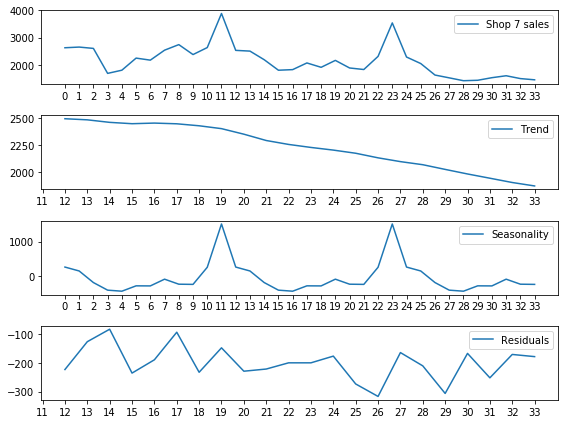

In [0]:
shop_7 = shops_sales[shops_sales['shop_id'] == 7]
shop_7 = shop_7.loc[:, '0':].T
decomposition = seasonal_decompose(shop_7, freq = 12, two_sided = False)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(shop_7, label='Shop 7 sales')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

Any method that we use to estimate trend and seanonality in the data requires to throw away historical data. By example: to find the trend and seasonality for shop 7 sales, we needed to throw away data of the first year.


**Notes**
- Not all pairs(shop/item) have trend or seasonality (it is hard to analyse all pairs manually by ploting their sales)
- lots of shops start selling late and lots of items start to be sold also late. This means first year of data is not enough to estimate accuretly those measures

### shop/item sales

In [0]:
for month in range(5, 34):
    pairs = shops_items_trans[shops_items_trans.loc[:,'0': str(month)].sum(axis=1) == 0]
    percent = round(100 * len(pairs) / len(shops_items_trans), 2)
    print('Until month: ', month, ', ', percent, '%, Item/Shops Pairs have made No sales')

Until month:  5 ,  56.85 %, Item/Shops Pairs have made No sales
Until month:  6 ,  53.64 %, Item/Shops Pairs have made No sales
Until month:  7 ,  50.63 %, Item/Shops Pairs have made No sales
Until month:  8 ,  48.04 %, Item/Shops Pairs have made No sales
Until month:  9 ,  45.2 %, Item/Shops Pairs have made No sales
Until month:  10 ,  42.31 %, Item/Shops Pairs have made No sales
Until month:  11 ,  38.64 %, Item/Shops Pairs have made No sales
Until month:  12 ,  36.79 %, Item/Shops Pairs have made No sales
Until month:  13 ,  34.89 %, Item/Shops Pairs have made No sales
Until month:  14 ,  32.67 %, Item/Shops Pairs have made No sales
Until month:  15 ,  30.55 %, Item/Shops Pairs have made No sales
Until month:  16 ,  28.46 %, Item/Shops Pairs have made No sales
Until month:  17 ,  26.6 %, Item/Shops Pairs have made No sales
Until month:  18 ,  24.86 %, Item/Shops Pairs have made No sales
Until month:  19 ,  23.02 %, Item/Shops Pairs have made No sales
Until month:  20 ,  21.14 %, Ite

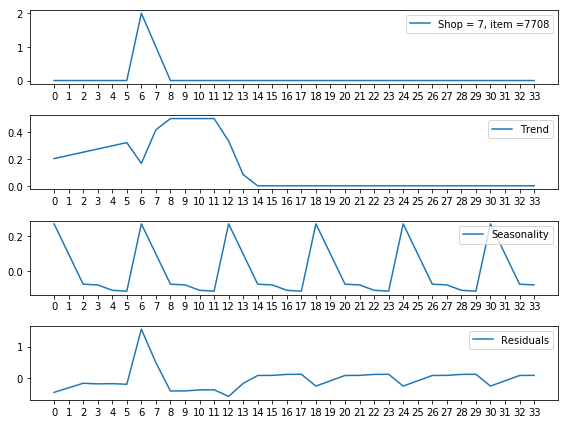

In [0]:
shop_item = shops_items_sales[shops_items_sales['shop_id'] == 7].sample(1)
shop_item_sale = shop_item.loc[:, '0':].T
decomposition = seasonal_decompose(shop_item_sale, freq = 6, two_sided = False, extrapolate_trend = 6)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(shop_item_sale, label='Shop = 7, item =' + str(shop_item['item_id'].values[0]))
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [0]:
dt_shops_items_sales = detrend_df_sales(shops_items_sales).T
nshops_items_sales = shops_items_sales.loc[:, ['shop_id', 'item_id']]
nshops_items_sales = pd.concat([nshops_items_sales, dt_shops_items_sales], axis = 1)

### Items sales

In [0]:
for month in range(5, 34):
    items_temp = items_trans[items_trans.loc[:,'0': str(month)].sum(axis=1) == 0]
    percent = round(100 * len(items_temp) / len(items_trans), 2)
    print('Until month: ', month, ', ', percent, '%, Items have made No sales')

Until month:  5 ,  44.9 %, Items have made No sales
Until month:  6 ,  42.87 %, Items have made No sales
Until month:  7 ,  40.75 %, Items have made No sales
Until month:  8 ,  39.02 %, Items have made No sales
Until month:  9 ,  36.05 %, Items have made No sales
Until month:  10 ,  33.78 %, Items have made No sales
Until month:  11 ,  31.36 %, Items have made No sales
Until month:  12 ,  30.42 %, Items have made No sales
Until month:  13 ,  28.87 %, Items have made No sales
Until month:  14 ,  27.47 %, Items have made No sales
Until month:  15 ,  26.02 %, Items have made No sales
Until month:  16 ,  24.84 %, Items have made No sales
Until month:  17 ,  23.69 %, Items have made No sales
Until month:  18 ,  22.24 %, Items have made No sales
Until month:  19 ,  21.11 %, Items have made No sales
Until month:  20 ,  19.57 %, Items have made No sales
Until month:  21 ,  17.03 %, Items have made No sales
Until month:  22 ,  14.94 %, Items have made No sales
Until month:  23 ,  12.79 %, Items

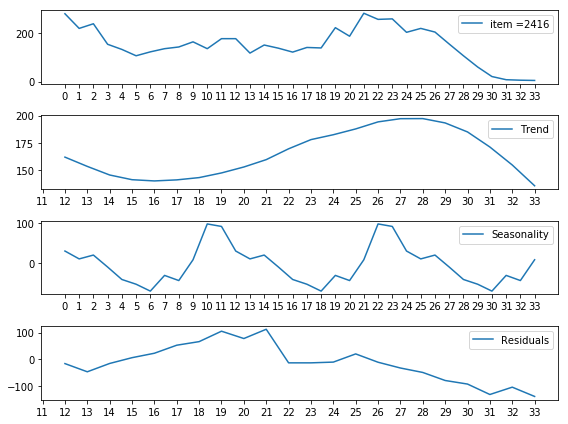

In [0]:
item_temp = items_sales.nlargest(50, columns = [str(itr) for itr in np.arange(27, 34)]).sample(1)
#item = items_sales.sample(1)
item_temp_sales = item_temp.loc[:, '0':].T
decomposition = seasonal_decompose(item_temp_sales, freq = 12, two_sided = False, extrapolate_trend = 0)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(item_temp_sales, label='item =' + str(item_temp['item_id'].values[0]))
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

Although the lake of data about item sales. But we can detrend and deseasonlize their sales. We assume that although the randomness of demand on items but there is lots of items that people buy in certain time of the year and in general all items are sold less than before.

In [0]:
dt_items_sales = detrend_df_sales(items_sales).T
nitems_sales = items_sales.loc[:, 'item_id']
nitems_sales = pd.concat([nitems_sales, dt_items_sales], axis = 1)

### shops sales

In [0]:
for month in range(5, 34):
    shops_temp = shops_trans[shops_trans.loc[:,'0': str(month)].sum(axis=1) == 0]
    percent = round(100 * len(shops_temp) / len(shops_trans), 2)
    print('Until month: ', month, ', ', percent, '%, Items have made No sales')

Until month:  5 ,  14.55 %, Items have made No sales
Until month:  6 ,  14.55 %, Items have made No sales
Until month:  7 ,  14.55 %, Items have made No sales
Until month:  8 ,  14.55 %, Items have made No sales
Until month:  9 ,  12.73 %, Items have made No sales
Until month:  10 ,  12.73 %, Items have made No sales
Until month:  11 ,  10.91 %, Items have made No sales
Until month:  12 ,  10.91 %, Items have made No sales
Until month:  13 ,  10.91 %, Items have made No sales
Until month:  14 ,  9.09 %, Items have made No sales
Until month:  15 ,  7.27 %, Items have made No sales
Until month:  16 ,  7.27 %, Items have made No sales
Until month:  17 ,  7.27 %, Items have made No sales
Until month:  18 ,  5.45 %, Items have made No sales
Until month:  19 ,  3.64 %, Items have made No sales
Until month:  20 ,  3.64 %, Items have made No sales
Until month:  21 ,  1.82 %, Items have made No sales
Until month:  22 ,  1.82 %, Items have made No sales
Until month:  23 ,  1.82 %, Items have mad

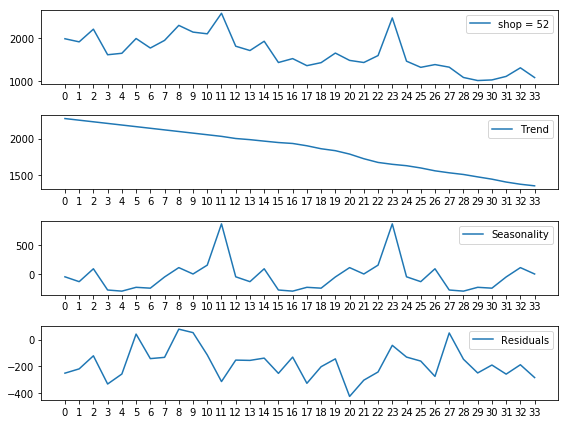

In [0]:
shop_temp = shops_sales.sample(1)
shop_temp_sales = shop_temp.loc[:, '0':].T
decomposition = seasonal_decompose(shop_temp_sales, freq = 12, two_sided = False, extrapolate_trend = 6)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(shop_temp_sales, label='shop = '+str(shop_temp['shop_id'].values[0]))
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

Time series analysis is powerful and by detrending and deseasonalizing the data you throw away unneeded complexity in the data.

In our case, we don't have enough sales history to perform such analysis. Indeed if you perform this analysis on the data you get nice score on the training set and validation set but your model will fail to generlize to the test set. The sales history for items/shops is relativly small and as a result the model will overfit miserably since the model will not be able to find general patterns in the noise of the sales data (no enough data).

In [0]:
dt_shops_sales = detrend_df_sales(shops_sales).T
nshops_sales = shops_sales.loc[:, 'shop_id']
nshops_sales = pd.concat([nshops_sales, dt_shops_sales], axis = 1)

## Lag features

In [0]:
from statsmodels.tsa.stattools import acf
time_shift = 14

### How much to go back in time for pairs(shop/item)
choose 100 pairs and compute how much the previous values of the series (lags) may be helpful in predicting the current value. 

In [0]:
shops_items_sales_temp = shops_items_sales.sample(1000)#.nlargest(10**4, columns = [str(itr) for itr in range(27, 33)])
pairs_acf = np.zeros((shops_items_sales_temp.shape[0], time_shift + 1))
for i, (ind, shop_item_sales) in enumerate(shops_items_sales_temp.iterrows()):
    pair = shop_item_sales.loc['0': ]
  #if np.sum(pair) != 0:
    acf_12 = acf(pair, nlags = time_shift, fft = True)
    pairs_acf[i, :] = acf_12

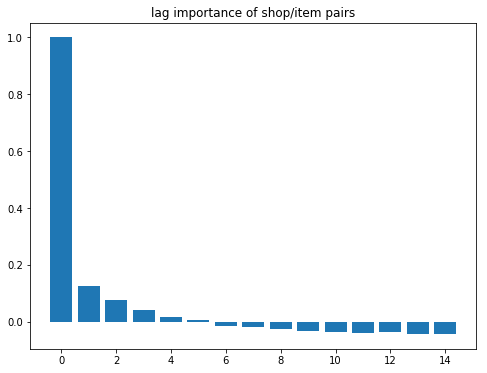

In [75]:
avgs = np.mean(pairs_acf, axis = 0)
plt.bar(x = np.arange(time_shift + 1), height = avgs)
plt.title('lag importance of shop/item pairs')
plt.show()

In [0]:
pair_lags = [1, 2, 3, 4, 9, 10, 11, 12]

### How much to go back in time for items

In [0]:
items_acf = np.zeros((items_sales.shape[0], time_shift + 1))
for i, item_sales in items_sales.iterrows():
    item_temp = item_sales.loc['0': ]
    if np.sum(item_temp) != 0:
        acf_12 = acf(item_temp, nlags = time_shift, fft = True)
        items_acf[i, :] = acf_12

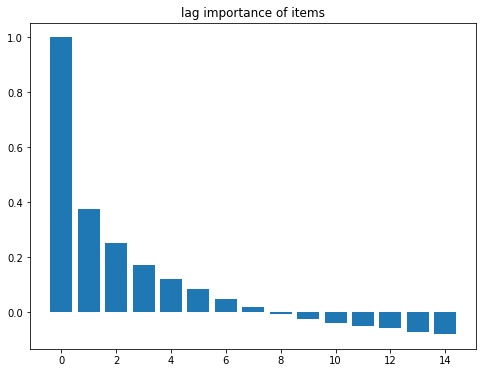

In [78]:
avgs = np.mean(items_acf, axis = 0)
plt.bar(x = np.arange(time_shift + 1), height = avgs)
plt.title('lag importance of items')
plt.show()

In [0]:
item_lags = [1, 2, 3, 4, 5, 6, 11, 12]

### How much to go back in time for shops

In [0]:
shops_acf = np.zeros((shops_sales.shape[0], time_shift + 1))
for i, shop_sales in shops_sales.iterrows():
    shop_temp = shop_sales.loc['0': ]
    acf_12 = acf(shop_temp, nlags = time_shift, fft = True)
    shops_acf[i, :] = acf_12

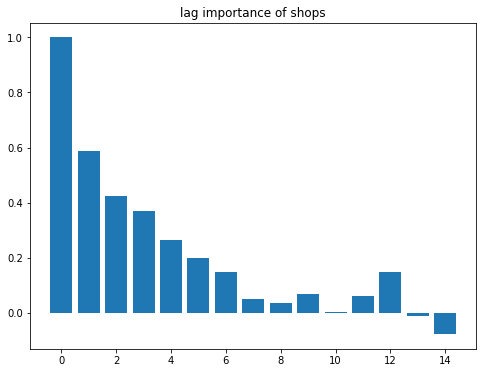

In [81]:
avgs = np.mean(shops_acf, axis = 0)
plt.bar(x = np.arange(time_shift + 1), height = avgs)
plt.title('lag importance of shops')
plt.show()

In [0]:
shop_lags = [1, 2, 3, 4, 5, 6, 9, 12]

### How much to go back in time for categories

In [0]:
categories_acf = np.zeros((categories_sales.shape[0], time_shift + 1))
for i, category_sales in categories_sales.iterrows():
    category_temp = category_sales.loc['0': ]
    acf_12 = acf(category_temp, nlags = time_shift, fft = True)
    categories_acf[i, :] = acf_12

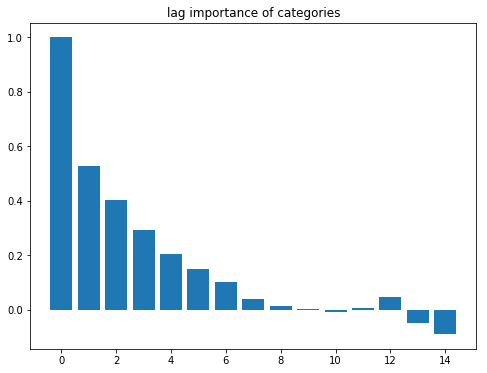

In [84]:
avgs = np.mean(categories_acf, axis = 0)
plt.bar(x = np.arange(time_shift + 1), height = avgs)
plt.title('lag importance of categories')
plt.show()

In [0]:
category_lags = [1, 2, 3, 4, 5, 6, 12]

## Create training grid and add lags to it

In [86]:
start = time.time()
grid = create_train_set(sales, index_cols)
test['date_block_num'] = 34
grid = pd.concat([grid, test], ignore_index = True, sort = False, keys = index_cols)
grid = grid.merge(items[['item_id', 'item_category_id']], on = 'item_id', how = 'left')
print(round(time.time() - start), 'seconds')

Sales data shape: (2935842, 7)
Generated Train data shape: (10809347, 4)
23 seconds


In [0]:
def lag_ex_features(grid, features, features_sales, features_lags):
    df = grid.copy()
    for feature_lag in features_lags:
        max_month = df.date_block_num.max()
        cols = [str(itr) for itr in np.arange(0, max_month)]
        gb = features_sales.melt( id_vars = features, 
                                 var_name = 'date_block_num' , 
                                 value_vars= cols, 
                                 value_name = '_'.join(features) + '_lag_' + str(feature_lag)
                                )
        gb.date_block_num = gb.date_block_num.astype(np.int16)
        gb.date_block_num = gb.date_block_num + feature_lag
        df = pd.merge(df, gb, on = features + ['date_block_num'], how='left')
    return df
  

In [0]:
def lag_features(grid, features, features_lags):
    df = grid.copy()
    for month_shift in features_lags:
        df_shift = df[index_cols + features].copy()
        df_shift['date_block_num'] = df_shift['date_block_num'] + month_shift
        lag_cols = lambda x: '{}_lag_{}'.format(x, month_shift) if x in features else x
        df_shift = df_shift.rename(columns = lag_cols)
        df = pd.merge(df, df_shift, on = index_cols, how='left')
    return df

In [89]:
start = time.time()
grid = lag_features(grid, ['target'], pair_lags)
print(round(time.time() - start), 'seconds')

73 seconds


In [90]:
start = time.time()
grid = lag_ex_features(grid, ['item_id'], items_sales, item_lags)
print(round(time.time() - start), 'seconds')

23 seconds


In [91]:
start = time.time()
grid = lag_ex_features(grid, ['shop_id'], shops_sales, shop_lags)
print(round(time.time() - start), 'seconds')

17 seconds


In [92]:
start = time.time()
grid = lag_ex_features(grid, ['item_category_id'], categories_sales, category_lags)
print(round(time.time() - start), 'seconds')

17 seconds


In [93]:
grid.isnull().sum()

shop_id                          0
item_id                          0
date_block_num                   0
target                      214200
item_category_id                 0
target_lag_1               2466770
target_lag_2               3091897
target_lag_3               3688208
target_lag_4               4253668
target_lag_9               6724591
target_lag_10              7129579
target_lag_11              7524904
target_lag_12              7884005
item_id_lag_1               372306
item_id_lag_2               739866
item_id_lag_3              1113456
item_id_lag_4              1479981
item_id_lag_5              1855236
item_id_lag_6              2245224
item_id_lag_11             4081468
item_id_lag_12             4471226
shop_id_lag_1               357060
shop_id_lag_2               724620
shop_id_lag_3              1098210
shop_id_lag_4              1464735
shop_id_lag_5              1839990
shop_id_lag_6              2229978
shop_id_lag_9              3332423
shop_id_lag_12      

In [0]:
grid = grid[grid['date_block_num'] > 11]
grid = grid.fillna(0)

## Item Price

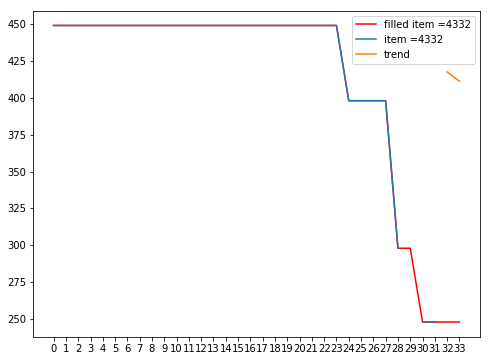

,item_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33
4332,4332,449.0,449.0,449.0,449.0,449.0,449.0,449.0,449.0,449.0,449.0,449.0,449.0,449.0,449.0,449.0,449.0,449.0,449.0,449.0,449.0,449.0,449.0,449.0,449.0,398.0,398.0,398.0,398.0,298.0,NaN,248.0,248.0,NaN,NaN


In [95]:
item_temp = nitems_prices.sample(1)#[items_prices['item_id'] == 17523]
item_temp_prices = item_temp.loc[:, '0':].T
filled_item_temp_prices = item_temp_prices.fillna(method = 'ffill')
filled_item_temp_prices = filled_item_temp_prices.fillna(method = 'bfill')

decomposition = seasonal_decompose(filled_item_temp_prices, freq = 32, two_sided = False)
trend = decomposition.trend

plt.plot(filled_item_temp_prices, label='filled item =' + str(item_temp['item_id'].values[0]), color = 'red')
plt.plot(item_temp_prices, label='item =' + str(item_temp['item_id'].values[0]))
plt.plot(trend, label='trend')
plt.legend(loc='best')
plt.show()
item_temp

In [0]:
filled_items_prices = nitems_prices.copy()
filled_items_prices.loc[:, '0':] =  filled_items_prices.loc[:, '0':].fillna(method = 'ffill', axis = 1)
filled_items_prices.loc[:, '0':] =  filled_items_prices.loc[:, '0':].fillna(method = 'bfill', axis = 1)
filled_items_prices_temp = filled_items_prices.loc[:, '0':'33'].T
decomposition = seasonal_decompose(filled_items_prices_temp, freq = 32, two_sided = False)
trend = decomposition.trend
trend = trend.T
trend = trend.dropna(axis = 1)
trend.columns = ['trend32', 'trend33']
trend.trend32 = round(trend.trend32, 4)
trend.trend33 = round(trend.trend33, 4)
filled_items_prices = pd.concat([filled_items_prices, trend], axis = 1)

In [0]:
filled_items_prices['item_price_status'] ='constant'
filled_items_prices.loc[filled_items_prices['trend32'] < filled_items_prices['trend33'], 'item_price_status'] = 'increasing'
filled_items_prices.loc[filled_items_prices['trend32'] > filled_items_prices['trend33'], 'item_price_status'] = 'decreasing'
filled_items_prices = filled_items_prices.drop(columns = ['trend32', 'trend33'], axis = 0)

In [0]:
filled_items_prices['item_price_avg'] = filled_items_prices.loc[:, '0':].median(axis = 1)

In [0]:
items = items.merge(filled_items_prices[['item_id', 'item_price_status', 'item_price_avg']], on = 'item_id', how = 'left')

## In how many shops each item is getting sold

In [0]:
gb = sales.groupby('item_id')[['shop_id']].nunique()
gb.columns = ['item_sold_in_shops']
gb = gb.reset_index()
grid = grid.merge(gb, on = ['item_id'], how = 'left')

## How many items does each shop contains(has sold)

In [0]:
gb = sales.groupby('shop_id')[['item_id']].nunique()
gb.columns = ['shop_sold_items']
gb = gb.reset_index()
grid = grid.merge(gb, on = ['shop_id'], how = 'left')

## How many items per category

In [0]:
gb = sales.groupby('item_category_id')[['item_id']].nunique()
gb.columns = ['items_per_category']
gb = gb.reset_index()
grid = grid.merge(gb, on = ['item_category_id'], how = 'left')

## How many categories each shop has

In [0]:
gb = sales.groupby('shop_id')[['item_category_id']].nunique()
gb.columns = ['shop_sold_categories']
gb = gb.reset_index()
grid = grid.merge(gb, on = ['shop_id'], how = 'left')

## Statistics

In [0]:
def create_df_stats(df, stat_name, attr):
    gb = df.copy()
    max_month =  df.columns.values[-1]
    
    gb[attr + '_sum'] = gb.loc[:, '0': str(max_month)].sum(axis = 1)
    gb[attr + '_max'] = gb.loc[:, '0': str(max_month)].max(axis = 1)
    gb[attr + '_std'] = gb.loc[:, '0': str(max_month)].std(axis = 1)
    gb[attr + '_median'] = gb.loc[:, '0': str(max_month)].median(axis = 1)
    gb = gb.drop(columns = [str(itr) for itr in np.arange(34)], axis = 0)
    return gb

### Pairs stats

In [0]:
gb = create_df_stats(shops_items_sales, 'pairs', 'pair')
gb = gb.drop(columns = ['pair_median'], axis = 0)

In [0]:
grid = grid.merge(gb, on = ['shop_id', 'item_id'], how = 'left')

In [0]:
grid = grid.fillna(0)

### item stats

In [0]:
gb = create_df_stats(items_sales, 'items', 'item')
gb = gb.drop(columns = ['item_median'], axis = 0)

In [0]:
grid = grid.merge(gb, on = ['item_id'], how = 'left')

### Shop stats

In [0]:
gb = create_df_stats(shops_sales, 'shops', 'shop')

In [0]:
grid = grid.merge(gb, on = ['shop_id'], how = 'left')

### Category stats

In [0]:
gb = create_df_stats(categories_sales, 'categories', 'category')

In [0]:
grid = grid.merge(gb, on = ['item_category_id'], how = 'left')

## Transactions

### shop/item transactions

In [0]:
shops_items_trans['shop_item_trans'] = shops_items_trans.loc[:, '0':'33'].sum(axis = 1)
grid = grid.merge(shops_items_trans[['shop_id', 'item_id', 'shop_item_trans']], on = ['shop_id', 'item_id'], how = 'left')

### item transactions

In [0]:
items_trans['item_trans'] = items_trans.loc[:, '0':'33'].sum(axis = 1)
grid = grid.merge(items_trans[['item_id', 'item_trans']], on = 'item_id', how = 'left')

### shop transactions

In [0]:
shops_trans['shop_trans'] = shops_trans.loc[:, '0':'33'].sum(axis = 1)
grid = grid.merge(shops_trans[['shop_id', 'shop_trans']], on = 'shop_id', how = 'left')

### category transactions

In [0]:
categories_trans['category_trans'] = categories_trans.loc[:, '0':'33'].sum(axis = 1)
grid = grid.merge(categories_trans[['item_category_id', 'category_trans']], on = 'item_category_id', how = 'left')

## Date Features

In [0]:
dates_train = sales.loc[:, ['date', 'date_block_num']].drop_duplicates()
dates_train = dates_train.reset_index(drop = True)
dates_test = dates_train.loc[dates_train.loc[:, 'date_block_num'] == 34 - 12]
dates_test = dates_test.reset_index(drop=True)
dates_test.loc[:,'date_block_num'] = 34
dates_test.loc[:, 'date'] = dates_test.loc[:, 'date'] + pd.DateOffset(years = 1)
dates_all = pd.concat([dates_train, dates_test])
dates_all.loc[:, 'dow'] = dates_all.loc[:, 'date'].dt.dayofweek
dates_all.loc[:, 'year'] = dates_all.loc[:, 'date'].dt.year

dates_all.loc[:, 'month'] = dates_all.loc[:, 'date'].dt.month
dates_all = pd.get_dummies(dates_all, columns = ['dow'])

dow_col = ['dow_' + str(x) for x in range(7)]

date_features = dates_all.groupby(['year', 'month', 'date_block_num'])[dow_col].agg('sum').reset_index()

date_features.loc[:, 'days_of_month'] = date_features.loc[:, dow_col].sum(axis=1)

date_features.loc[:, 'year'] = date_features.loc[:, 'year'] - 2013

date_features = date_features.loc[:, ['month', 'year', 'days_of_month', 'date_block_num']]

In [0]:
grid = grid.merge(date_features, on = 'date_block_num', how = 'left')

## Item selling duration/First sale/last sale

In [0]:
def get_sale_info(row, name):
    duration = 0
    sale_start = 34
    first_sale = 0
    sale_end = 34
    last_sale = 0
    for month in np.arange(34):
        if row[str(month)] > 0:
            duration = duration + 1
    for month in np.arange(34):
        if row[str(month)] > 0:
            sale_start = month
            first_sale = row[str(month)]
            break
    for month in np.arange(34):
        if row[str( 33 - month)] > 0:
            sale_end = 33 - month
            last_sale = row[str(33 - month)]
            break
    row[name + '_sale_start'] = sale_start
    row[name + '_first_sale'] = first_sale
    row[name + '_sale_end'] = sale_end
    row[name + '_last_sale'] = last_sale
    row[name + '_selling_duration'] = duration
    return row
   

In [123]:
start = time.time()
items_sales_info = items_sales.apply(get_sale_info, axis = 1, name = 'item')
items_sales_info = items_sales_info.drop(columns = [str(itr) for itr in np.arange(34)], axis = 0)
print(round(time.time() - start), 'seconds')

134 seconds


In [0]:
grid = grid.merge(items_sales_info, on = 'item_id', how = 'left')

## shop selling duration/First sale/last sale

In [125]:
start = time.time()
shops_sales_info = shops_sales.apply(get_sale_info, axis = 1, name = 'shop')
shops_sales_info = shops_sales_info.drop(columns = [str(itr) for itr in np.arange(34)], axis = 0)
print(round(time.time() - start), 'seconds')

0 seconds


In [0]:
grid = grid.merge(shops_sales_info, on = 'shop_id', how = 'left')

## category selling duration/First sale/last sale

In [127]:
start = time.time()
categories_sales_info = categories_sales.apply(get_sale_info, axis = 1, name = 'category')
categories_sales_info = categories_sales_info.drop(columns = [str(itr) for itr in np.arange(34)], axis = 0)
print(round(time.time() - start), 'seconds')

1 seconds


In [0]:
grid = grid.merge(categories_sales_info, on = 'item_category_id', how = 'left')

In [131]:
grid.isnull().sum()

shop_id                            0
item_id                            0
date_block_num                     0
target                             0
item_category_id                   0
target_lag_1                       0
target_lag_2                       0
target_lag_3                       0
target_lag_4                       0
target_lag_9                       0
target_lag_10                      0
target_lag_11                      0
target_lag_12                      0
item_id_lag_1                      0
item_id_lag_2                      0
item_id_lag_3                      0
item_id_lag_4                      0
item_id_lag_5                      0
item_id_lag_6                      0
item_id_lag_11                     0
item_id_lag_12                     0
shop_id_lag_1                      0
shop_id_lag_2                      0
shop_id_lag_3                      0
shop_id_lag_4                      0
shop_id_lag_5                      0
shop_id_lag_6                      0
s

In [0]:
grid.shop_item_trans = grid.shop_item_trans.fillna(0)
grid.item_trans = grid.item_trans.fillna(0)

grid.item_sale_start = grid.item_sale_start.fillna(33)
grid.item_first_sale = grid.item_sale_start.fillna(0)

grid.item_sale_end = grid.item_sale_end.fillna(33)
grid.item_last_sale = grid.item_last_sale.fillna(0)

grid.item_selling_duration = grid.item_selling_duration.fillna(0)

## Feature Interaction

### Item/category

In [0]:
grid['item_category_inter'] = grid['item_id'].astype(str) + '_' + grid['item_category_id'].astype(str)

In [0]:
grid.loc[:, 'item_category_inter'] = LabelEncoder().fit_transform(grid.loc[:, 'item_category_inter'].values)

### item/shop

In [0]:
grid['item_shop_inter'] = grid['item_id'].astype(str) + '_' + grid['shop_id'].astype(str)
grid.loc[:, 'item_shop_inter'] = LabelEncoder().fit_transform(grid.loc[:, 'item_shop_inter'].values)

### shop/category

In [0]:
grid['category_shop_inter'] = grid['item_category_id'].astype(str) + '_' + grid['shop_id'].astype(str)
grid.loc[:, 'category_shop_inter'] = LabelEncoder().fit_transform(grid.loc[:, 'category_shop_inter'].values)

## Add categorical features

### Item categorical features

In [0]:
for col in items.columns:
    if items[col].dtypes == np.object:
        items.loc[:, col] = LabelEncoder().fit_transform(items[col].values)

In [0]:
grid = grid.merge(items, on = ['item_id', 'item_category_id'], how = 'left')

### Categories categorical features

In [0]:
for col in categories.columns:
    if categories[col].dtypes == np.object:
        categories.loc[:, col] = LabelEncoder().fit_transform(categories[col].values)

In [0]:
grid = grid.merge(categories, on = 'item_category_id', how = 'left')

### shop categorical features

In [0]:
for col in shops.columns:
    if shops[col].dtypes == np.object:
        shops.loc[:, col] = LabelEncoder().fit_transform(shops[col].values)

In [0]:
grid = grid.merge(shops, on = 'shop_id', how = 'left')

# Save grid

In [149]:
print(grid.shape)

(6567567, 93)


In [0]:
grid = downcast_dtypes(grid)

Memory usage: 3251.97 MB
New Memory usage: 1977.20 MB


In [147]:
save_name = generate_name('grid_No_missing')
save_name

'grid_No_missing_06_57_56__15_Sep_2019'

In [148]:
start = time.time()
grid.to_pickle(data_path + save_name + '.pkl')
print(round(time.time() - start), 'seconds')

129 seconds
